In [1]:
from IPython.display import display, Image


# Introduction to Gradient Boosting Methods (GBMs)

We note that the following content mainly builds upon [Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html).

The technique of gradient boosting which has attracted significantly increasing attention in recent years due to its superior for solving
tabular data problems. The term **Gradient Boosting** originates from the paper *Greedy Function Approximation: A Gradient Boosting Machine*, by Friedman. This tutorial aims to provide a clear explanation on typical gradient boosting methods, such as gradient boosting decision trees (GBDT), in a self-contained and principled way using the elements of supervised learning.

## 1 Elements of Supervised Learning

First, we introduce the notations used throughout this tutorial as follows:

Given the training data $X=\{\mathbf{x}_i\}_{i=1}^{n}$, and the target $Y=\{y_i\}_{i=1}^{n}$, where $\mathbf{x}_i$ denotes the feature vector with respect to the $i$-th data instance, which can be either continuous or categorical features. $\mathbf{x}_{ij}$ denotes the $j$-th feature of $\mathbf{x}_i$.

### 1.1 Model and Parameters
The **model** in supervised learning usually refers to the mathematical structure by which the prediction $\hat{y}_{i}$ is made given the input $\mathbf{x}_i$. A common example is a **linear model**, where the prediction is given as $\hat{y}_i = \sum_j \theta_j \mathbf{x}_{ij}$, namely a linear combination of weighted input features. The prediction value can have different interpretations, depending on the task, i.e., regression or classification. For example, it can be logistic transformed to get the probability of positive class in logistic regression, and it can also be used as a ranking score when we want to rank the outputs.

The **parameters** are the undetermined part that we need to learn from data. In linear regression problems, the parameters are the coefficients $\theta$. Usually we will use $\theta$ to denote the parameters.

### 1.2 Objective Function: Training Loss + Regularization
With judicious choices for $y_i$, we may express a variety of tasks, such as regression, classification, and ranking.
The task of **training** the model amounts to finding the best parameters $\theta$ that best fit the training data $\mathbf{x}_i$ and labels $y_i$. In order to train the model, we need to define the **objective function**
to measure how well the model fit the training data.

A salient characteristic of objective functions is that they consist two parts: **training loss** and **regularization term**:

\begin{equation}
\text{obj}(\theta) = L(\theta) + \Omega(\theta)
\end{equation}

where $L$ is the training loss function, and $\Omega$ is
the **regularization term**. The training loss measures how *predictive* our model is with respect to the training data. A common choice of $L$ is the *mean squared error*, which is given by

$L(\theta) = \sum_i (y_i-\hat{y}_i)^2$

Another commonly used loss function is logistic loss, to be used for logistic regression:

$$L(\theta) = \sum_i[ y_i\ln (1+e^{-\hat{y}_i}) + (1-y_i)\ln (1+e^{\hat{y}_i})]$$

The **regularization term** is what people usually forget to add. The regularization term controls the complexity of the model, which helps us to avoid overfitting.

### 1.3 Why introduce the general principle?
The elements introduced above form the basic elements of supervised learning, and they are natural building blocks of machine learning toolkits. For example, you should be able to describe the differences and commonalities between gradient boosted trees and random forests. Understanding the process in a formalized way also helps us to understand the objective that we are learning and the reason behind the heuristics such as pruning and smoothing.

## 2 Gradient Boosting Decision Trees (GBDT)

### 2.1 Tree Ensembles
Now that we have introduced the elements of supervised learning, let us get started with real trees. The tree ensemble model consists of a set of classification and regression trees (CART). Here's a simple example of a CART that classifies whether someone will like a hypothetical computer game X.

Fig. A toy example for CART
<img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/cart.png" />

We classify the members of a family into different leaves, and assign them the score on the corresponding leaf.
A CART is a bit different from decision trees, in which the leaf only contains decision values. In CART, a real score
is associated with each of the leaves, which gives us richer interpretations that go beyond classification.
This also allows for a principled, unified approach to optimization, as we will see in a later part of this tutorial.

Usually, a single tree is not strong enough to be used in practice. What is actually used is the ensemble model,
which sums the prediction of multiple trees together.

Fig. A toy example for tree ensemble, consisting of two CARTs
<img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png" />

Here is an example of a tree ensemble of two trees. The prediction scores of each individual tree are summed up to get the final score.
If you look at the example, an important fact is that the two trees try to **complement** each other.
Mathematically, we can write our model in the form

$$\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$$

where $K$ is the number of trees, $f$ is a function in the functional space $\mathcal{F}$, and $\mathcal{F}$ is the set of all possible CARTs. The objective function to be optimized is given by

$$\text{obj}(\theta) = \sum_i^n l(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k)$$

Now here comes a trick question: what is the **model** used in random forests? Tree ensembles! So random forests and boosted trees are really the same models; the difference arises from how we train them. This means that, if you write a predictive service for tree ensembles, you only need to write one and it should work for both random forests and gradient boosted trees. (See [Treelite](https://treelite.readthedocs.io/en/latest/index.html) for an actual example.) One example of why elements of supervised learning rock.

### 2.2 Tree Boosting

Now that we introduced the model, let us turn to training: How should we learn the trees?
The answer is, as is always for all supervised learning models: **define an objective function and optimize it**!

Let the following be the objective function (remember it always needs to contain training loss and regularization):

$$\text{obj} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i)$$

In particular, $t$ denotes the training step, each step also corresponds to a member function $f$, i.e., a tree.

### 2.3 Additive Training

The first question we want to ask: what are the **parameters** of trees? You can find that what we need to learn are those functions $f_i$, **each containing the structure of the tree and the leaf scores**. Learning tree structure is much harder than traditional optimization problem where you can simply take the gradient. **It is intractable to learn all the trees at once**.
Instead, we use an **additive strategy: fix what we have learned, and add one new tree at a time**. In other words, the functions $f_1$ ... $f_{t-1}$ would be viewed as learned functions when we learn $f_t$. We write the prediction value at **step** $t$ as $\hat{y}_i^{(t)}$. Then we have

\begin{equation}
\begin{split}
\hat{y}_i^{(0)} &= 0\\
  \hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
  \hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
  &\dots\\
  \hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)
\end{split}
\end{equation}

It remains to ask: which tree do we want at each step?  A natural thing is to add the one that optimizes our objective.

\begin{equation}
\begin{split}
  \text{obj}^{(t)} & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i) \\
            & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t) + \mathrm{constant}
\end{split}
\end{equation}

If we consider using mean squared error (MSE) as our loss function, the objective becomes

\begin{equation}
\begin{split}
  \text{obj}^{(t)} & = \sum_{i=1}^n (y_i - (\hat{y}_i^{(t-1)} + f_t(x_i)))^2 + \sum_{i=1}^t\Omega(f_i) \\
            & = \sum_{i=1}^n [2(\hat{y}_i^{(t-1)} - y_i)f_t(x_i) + f_t(x_i)^2] + \Omega(f_t) + \mathrm{constant}
\end{split}
\end{equation}

where the terms without $f_t$ are aggregated as a constant since the functions $f_1$ ... $f_{t-1}$ are learned functions in previous steps.

> In calculus, Taylor's theorem gives an approximation of a k-times
differentiable function around a given point by a polynomial of degree
k, called the kth-order Taylor polynomial. For a smooth function,
the Taylor polynomial is the truncation at the order k of the Taylor
series of the function.
>
> \begin{equation}
f(x)=\sum_{n=0}^{\infty}\frac{f^{(n)}(x_{0})}{n!}(x-x_{0})^{n}
\end{equation}
>
> The first-order Taylor polynomial is the linear approximation of the
function,
>
> $f(x)\approx f(x_{0})+f^{'}(x_{0})(x-x_{0})$
>
>The second-order Taylor polynomial is often referred to as the quadratic
approximation,
>
>$f(x)\approx f(x_{0})+f^{'}(x_{0})(x-x_{0})+f^{''}(x_{0})\frac{(x-x_{0})^{2}}{2}$

The form of MSE is friendly, with a first order term (usually called the residual) and a quadratic term.
For other losses of interest (for example, logistic loss), it is not so easy to get such a nice form.
So in the general case, we take the **Taylor expansion of the loss function up to the second order**:

\begin{equation}
\begin{split}
  \text{obj}^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + \mathrm{constant}
\end{split}
\end{equation}

where the $g_i$ and $h_i$ are defined as

\begin{equation}
\begin{split}
  g_i &= \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)})\\
  h_i &= \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)})
\end{split}
\end{equation}

> We note that the $f$ in the description on Taylor's theorem is different from $f_{t}$ in the loss function. Put another way, $g_i$ corresponds to $f^{'}(x_{0})$, $h_i$ corresponds to $f^{''}(x_{0})$, $f_t(x_i)$ corresponds to $x-x_{0}$, $\sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)})$ corresponds to $f(x_{0})$.

After we remove all the constants, the specific objective at step $t$ becomes

\begin{equation}
\begin{split}
  \sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t)
\end{split}
\end{equation}

**This becomes our optimization goal for the new tree**. One important advantage of this definition is that
the value of the objective function only depends on $g_i$ and $h_i$. This is how the popular packages, such as **XGBoost** and **LightGBM**, support custom loss functions.
**We can optimize every loss function, including logistic regression and pairwise ranking, using exactly the same solver that takes $g_i$ and $h_i$ as input**!

### 2.4 Model Complexity
We have introduced the training step, but wait, there is one important thing, the **regularization term**!
We need to define the complexity of the tree $\Omega(f)$. In order to do so, let us first refine the definition of the tree $f(x)$ as

\begin{equation}
\begin{split}
  f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\} .
\end{split}
\end{equation}

Here $w$ is the vector of scores on leaves, $q$ is a function assigning each data point to the corresponding leaf, and $T$ is the number of leaves.
In XGBoost, the complexity is defined as

\begin{equation}
\begin{split}
  \Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2
\end{split}
\end{equation}

Of course, there is more than one way to define the complexity, but this one works well in practice. The regularization is one part most tree packages treat
less carefully, or simply ignore. This was because the traditional treatment of tree learning only emphasized improving impurity, while the complexity control was left to heuristics.
By defining it formally, we can get a better idea of what we are learning and obtain models that perform well in the wild.

### 2.5 The Structure Score
Here is the magical part of the derivation. After re-formulating the tree model, we can write the objective value with the $t$-th tree as:

\begin{equation}
\begin{split}
  \text{obj}^{(t)} &\approx \sum_{i=1}^n [g_i w_{q(x_i)} + \frac{1}{2} h_i w_{q(x_i)}^2] + \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2\\
  &= \sum^T_{j=1} [(\sum_{i\in I_j} g_i) w_j + \frac{1}{2} (\sum_{i\in I_j} h_i + \lambda) w_j^2 ] + \gamma T
\end{split}
\end{equation}

where $I_j = \{i|q(x_i)=j\}$ is the set of indices of data points assigned to the $j$-th leaf.
Notice that in the second line we have changed the index of the summation because all the data points on the same leaf get the same score.
We could further compress the expression by defining $G_j = \sum_{i\in I_j} g_i$ and $H_j = \sum_{i\in I_j} h_i$:

\begin{equation}
\begin{split}
  \text{obj}^{(t)} = \sum^T_{j=1} [G_jw_j + \frac{1}{2} (H_j+\lambda) w_j^2] +\gamma T
\end{split}
\end{equation}

In this equation, $w_j$ are independent with respect to each other, the form $G_jw_j+\frac{1}{2}(H_j+\lambda)w_j^2$ is quadratic and the best $w_j$ for a given structure $q(x)$ and the best objective reduction we can get is:

\begin{equation}
\begin{split}
  w_j^\ast &= -\frac{G_j}{H_j+\lambda}\\
  \text{obj}^\ast &= -\frac{1}{2} \sum_{j=1}^T \frac{G_j^2}{H_j+\lambda} + \gamma T
\end{split}
\end{equation}

The last equation measures *how good* a tree structure $q(x)$ is.

Fig. An illustration of structure score (fitness)

<img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/struct_score.png" />

If all this sounds a bit complicated, let's take a look at the picture, and see how the scores can be calculated.
Basically, for a given tree structure, we push the statistics $g_i$ and $h_i$ to the leaves they belong to,
sum the statistics together, and use the formula to calculate how good the tree is.
This score is like the impurity measure in a decision tree, except that it also takes the model complexity into account.

### 2.6 Learn the tree structure
Now that we have a way to measure how good a tree is, ideally we would enumerate all possible trees and pick the best one.
In practice this is intractable, so we will try to optimize one level of the tree at a time.
Specifically we try to split a leaf into two leaves, and the score it gains is

\begin{equation}
\begin{split}
  Gain = \frac{1}{2} \left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right] - \gamma
\end{split}
\end{equation}

This formula can be decomposed as: 1) the score on the new left leaf, 2) the score on the new right leaf, 3) the score on the original leaf, 4) regularization on the additional leaf.
We can see an important fact here: if the gain is smaller than $\gamma$, we would do better not to add that branch. This is exactly the **pruning** techniques in tree based models! By using the principles of supervised learning, we can naturally come up with the reason these techniques work :)

### 2.7 Approximate Split Finding Using Feature Histograms

It is vital to find the optimal split of a tree node efficiently, as enumerating every possible split in a brute-force manner is impractical. Current works generally adopt a histogram-based algorithm for
fast and accurate split finding, like the following picture.

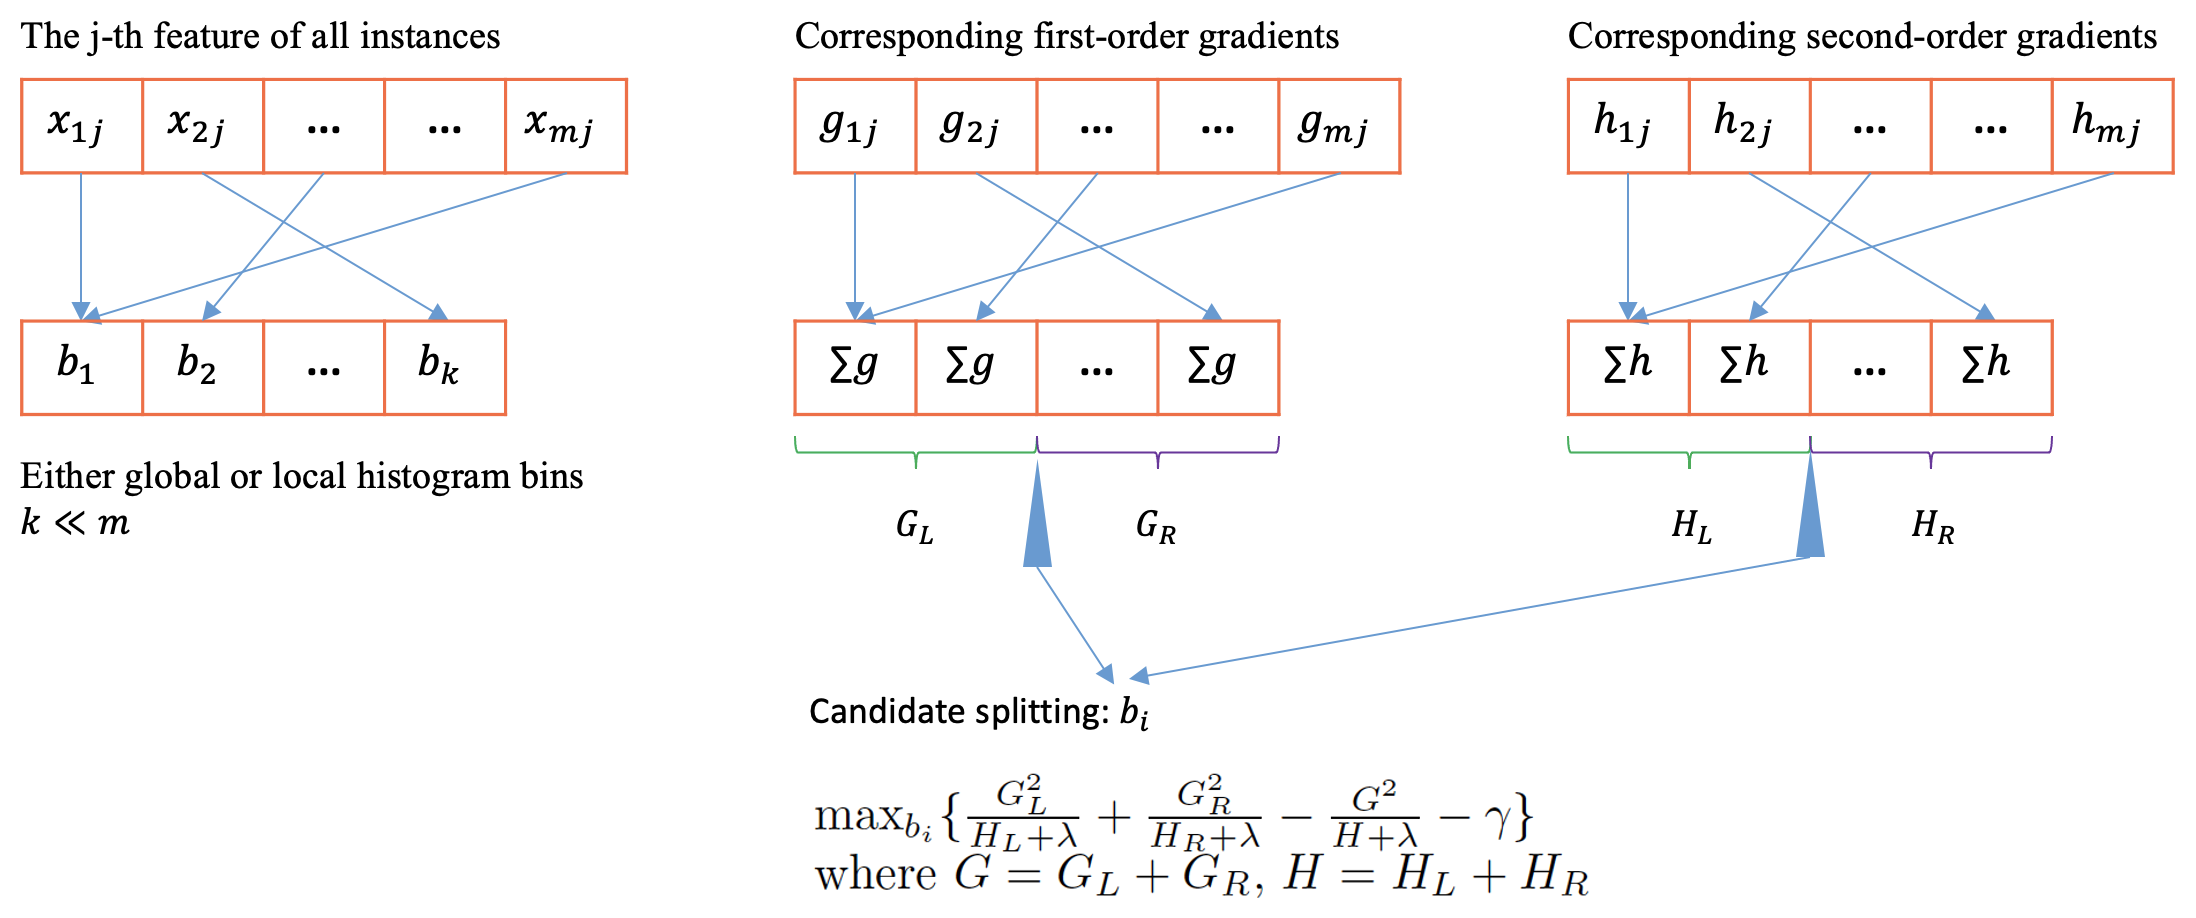

In [3]:
path_img_his = "../img/histogram_split.png"
img_ltr_perqdata = Image(path_img_his, width = 800, height = 100)
display(img_ltr_perqdata)

Specifically, the algorithm considers only $k$ values (i.e., number of bins) for each feature as candidate splits rather than all possible splits (e.g., all feature values). The most common approach to propose the candidates is using the **quantile sketch** to approximate the feature distribution. After candidate splits are prepared, we enumerate
all instances on a tree node and accumulate their gradient statistics into two histograms, first- and second-order gradients, respectively. The histogram consists of $k$ bins, each of which sums the first- or second-order gradients of instances whose $j$-th feature values fall into that bin. In this way, each feature is summarized by two histograms. We find the best split of $j$-th feature upon the histograms that achieve the maximum gain value and the global best split is the best split over all features.

Another advantage of the histogram-based algorithm is that we can accelerate the algorithm by a histogram subtraction technique. The instances on two children nodes are **non-overlapping and mutual exclusive**, since **an instance will be classified onto either left or right child node when the parent node gets split** (since the bins or histograms are naturally ordered). Considering the basic operation of histogram is adding gradients, therefore, for a specific feature, the element-wise sum of first or second-order histograms of children nodes equals to that of parent.

- Example case: using local bins

    Motivated by this, we can significantly accelerate training by first constructing the histograms of the one child node with fewer instances, and then getting those of the sibling node via histogram subtraction (histograms of parent node are persist in memory). By doing so, we can skip at least one half of the instances. Since histogram construction usually dominates the computation cost, such subtraction technique can speed up the training process considerably.

> Limitation of additive tree learning

  Since it is intractable to enumerate all possible tree structures, we add one split at a time. This approach works well most of the time, but there are some edge cases that fail due to this approach. For those edge cases, training results in a degenerate model because we consider only one feature dimension at a time. See [Can Gradient Boosting Learn Simple Arithmetic?](<http://mariofilho.com/can-gradient-boosting-learn-simple-arithmetic/>) for an example.